In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt

# Import the TCGA cancer data

In [2]:
folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20284)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:615: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID",how="left")
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:309: FutureWarning: 'symbol' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.HGNC_lncrna_info.groupby("symbol").first(), on="symbol",
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'Gene Name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)


Processed genes info for  LNC


# Heterogeneous Network

In [10]:
import pickle

with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_mi-lnc_filtered.pickle', 'rb') as file:
    network = pickle.load(file)

In [12]:
nodes = network.nodes
node_list = network.node_list

In [13]:
from moge.network.heterogeneous_network import HeterogeneousNetwork
# from moge.utils.omics_distance import compute_expression_correlations, compute_annotation_similarity
network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)


MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


In [7]:
# READ Edgeslist
network.import_edgelist_file(file="lncRNA-miRNA-mRNA_new-08-14.edgelist", 
                             is_directed=True)

In [8]:
network.G.number_of_edges()

4034787

In [16]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/lncRNA_miRNA_mRNA/lmn_network_filtered_directed.edgelist", 
                  data=False)

#### Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Node Similarity Edges

In [14]:
network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], similarity_threshold=0.80, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=3.0,
                                       features=["locus_type", "gene_family_id", "location"])

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing location , dtype: object , shape: (20284,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing arm , dtype: object , shape: (20284,)
Dice distance
Gower's dissimilarity: Computing region , dtype: object , shape: (20284,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:138: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:127: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


247533 undirected positive edges (type='u') added.
742599 undirected negative edges (type='u_n') added.


In [15]:
network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], similarity_threshold=0.80, dissimilarity_threshold=0.1,
                                        negative_sampling_ratio=5.0, 
                                        features=["miR family"])

Gower's dissimilarity: Computing miR family , dtype: object , shape: (1870,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:127: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


506 undirected positive edges (type='u') added.
2530 undirected negative edges (type='u_n') added.


In [16]:
network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], similarity_threshold=0.90, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=2.0,
                                        features=["Transcript Type", "Location", "Strand"])

Gower's dissimilarity: Computing Transcript Type , dtype: object , shape: (12725,)
Dice distance
Gower's dissimilarity: Computing Location , dtype: object , shape: (12725,)
Location split to Chromosome, start, end
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12725,)
Dice distance
Gower's dissimilarity: Computing start , dtype: float64 , shape: (12725,)
Euclidean distance (normalized ptp)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:138: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12725,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:127: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


368670 undirected positive edges (type='u') added.
737340 undirected negative edges (type='u_n') added.


In [18]:
network.nodes = nodes
network.node_list = node_list

In [19]:
network.remove_extra_nodes()

In [20]:
network.G.number_of_edges()

755212

In [ ]:
g_edges = network.G.edges()

# Add Regulatory Interaction edges

In [4]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRNA_target_interaction(), 
                                        modalities=["MIR", "GE"],
                                        )

Adding edgelist with 331 total unique MIR genes (source), but only matching 292 nodes
Adding edgelist with 13035 total unique GE genes (target), but only matching 12234 nodes
228767 edges added.


In [5]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(), # unweighted edges
                                         modalities=["GE", "GE"],
                                        )

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2907: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Adding edgelist with 13318 total unique GE genes (source), but only matching 12775 nodes
Adding edgelist with 19429 total unique GE genes (target), but only matching 14995 nodes
313724 edges added.


In [6]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
                                         modalities=["MIR", "LNC"]
                                        )

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_lncRNA_miRNA_interactions_edgelist(),
                                         modalities=["MIR", "LNC"])

Adding edgelist with 978 total unique MIR genes (source), but only matching 893 nodes
Adding edgelist with 66 total unique LNC genes (target), but only matching 31 nodes
2375 edges added.
Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 6185 total unique LNC genes (target), but only matching 1760 nodes
53926 edges added.


In [7]:
# network.remove_extra_nodes()
isolates = list(nx.isolates(network.G))

In [8]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [10]:
# network.remove_extra_nodes() # Also makes network unmutable

In [13]:
network.G.number_of_edges()

520113

# Split train-test

In [21]:
from moge.evaluation.utils import split_train_test_network

network_train, val_edges_dict, test_edges_dict = split_train_test_network(network, network.node_list, 
                                                          test_frac=.01, val_frac=.15, edge_types=["u", "d", "u_n"], 
                                                          seed=0)

NetworkXError: SubGraph Views are readonly. Mutations not allowed

In [12]:
network_train.G.number_of_edges()

520113

In [10]:
network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)
node_list = network_train.node_list

MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879
MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


In [11]:
for edge_type, edges in test_edges_dict.items():
    for edge in edges:
        network_test.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type)
print(network_test.G.number_of_edges())
for edge_type, edges in val_edges_dict.items():
    for edge in edges:
        network_val.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type)
print(network_val.G.number_of_edges())

4898
73473


In [15]:
# WRITE
import pickle
with open('moge/data/lncRNA_miRNA_mRNA/lmn_network_lncbase_filtered_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/lncRNA_miRNA_mRNA/lmn_network_lncbase_filtered_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/lncRNA_miRNA_mRNA/lmn_network_lncbase_filtered_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

##### Save/Load to file

In [15]:
import pickle

with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_mi-lnc_filtered.pickle', 'wb') as file:
    pickle.dump(network, file)


# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [33]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

TypeError: object of type 'generator' has no len()

In [34]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

40387
29997382


In [42]:
csr_un = network.get_adjacency_matrix(edge_type="u_n", node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_type="u", node_list=network.node_list)

In [48]:
network.get_adjacency_matrix(edge_type="n", node_list=network.node_list)

<34879x34879 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

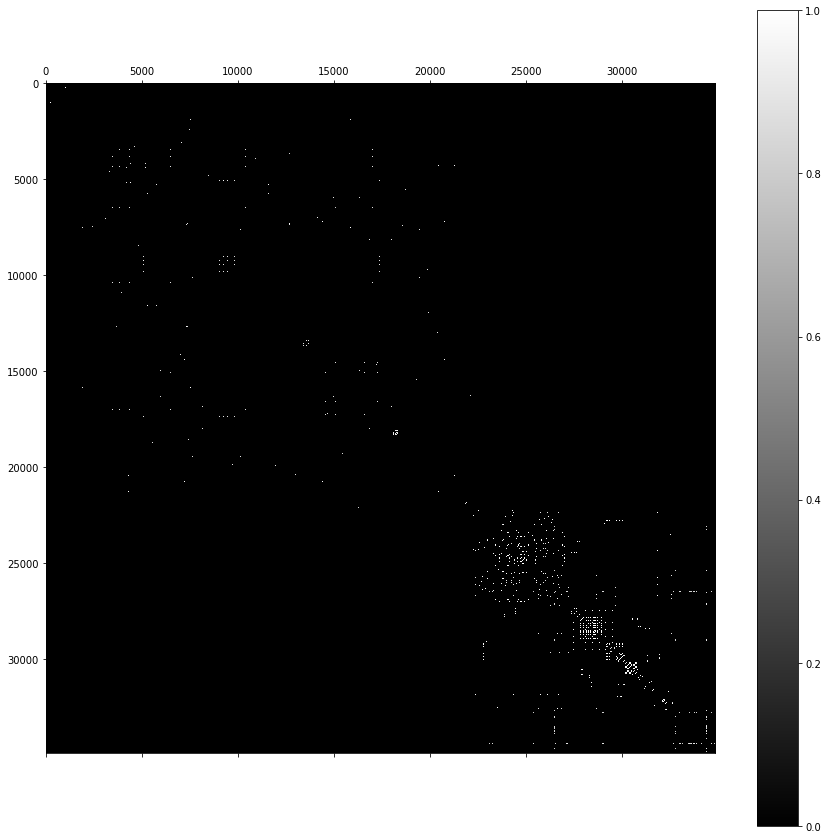

In [47]:
import matplotlib.pyplot as plt
# Scatter plot of original graph adjacency matrix
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(csr_un.toarray(), interpolation='nearest', cmap=plt.cm.gray)
fig.colorbar(cax)

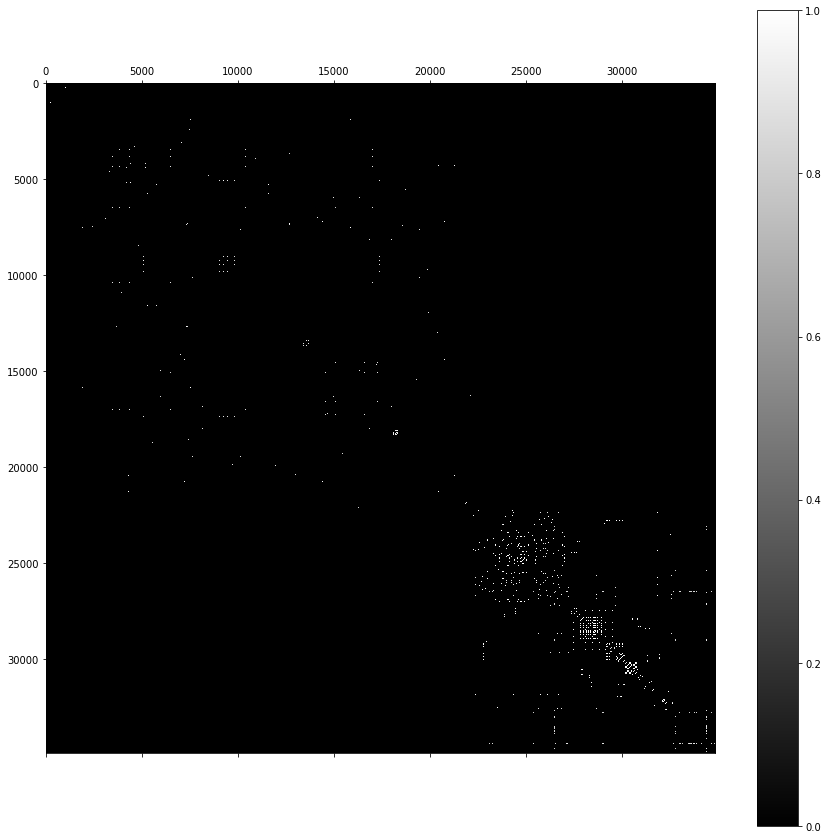

In [46]:
import matplotlib.pyplot as plt
# Scatter plot of original graph adjacency matrix
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(csr_u.toarray(), interpolation='nearest', cmap=plt.cm.gray)
fig.colorbar(cax)